# LSTM Model

### Made By Team 9:

|   NIM    |            Name            |
| :------: | :------------------------: |
| 13522037 |    Farhan Nafis Rayhan     |
| 13522071 |   Bagas Sambega Rosyada    |
| 13522091 | Raden Francisco Trianto B. |


## Implementasi Model LSTM Keras

In [1]:
import os
import json
import numpy as np
from typing import Any, List, Tuple, Dict, Union
from keras import layers, models, losses, optimizers
from keras.callbacks import History
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


class LSTMModel:
    def __init__(
        self,
        vocab_size: int,
        sequence_length: int = 100,
        embedding_dim: int = 128,
        lstm_layers: int = 1,
        lstm_units: Union[int, List[int]] = 64,
        bidirectional: bool = False,
        dense_units: List[int] = [128],
        dense_activations: List[str] = ["relu"],
    ):
        if isinstance(lstm_units, int):
            lstm_units = [lstm_units] * lstm_layers

        self.model = self._build_model(
            vocab_size,
            sequence_length,
            embedding_dim,
            lstm_layers,
            lstm_units,
            bidirectional,
            dense_units,
            dense_activations
        )

    def _build_model(
        self, vocab_size, seq_len, embed_dim, lstm_layers, lstm_units,
        bidirectional, dense_units, dense_activations
    ):
        model = models.Sequential(name="lstm_nusax")
        model.add(layers.Input(shape=(seq_len,), name="input"))
        model.add(layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, name="embedding"))

        for i in range(len(lstm_units)):
            return_seq = i < len(lstm_units) - 1
            lstm_layer = layers.LSTM(lstm_units[i], return_sequences=return_seq, name=f"lstm_{i+1}")
            if bidirectional:
                lstm_layer = layers.Bidirectional(lstm_layer, name=f"bilstm_{i+1}")
            model.add(lstm_layer)

        model.add(layers.Dropout(0.5, name="dropout"))

        for idx, (units, act) in enumerate(zip(dense_units, dense_activations)):
            model.add(layers.Dense(units, activation=act, name=f"dense_{idx+1}"))

        model.add(layers.Dense(3, activation="softmax", name="output"))
        return model

    def compile(self):
        self.model.compile(
            loss=losses.SparseCategoricalCrossentropy(),
            optimizer=optimizers.Adam(),
            metrics=["accuracy"],
        )

    def train(
        self, x_train, y_train, x_val, y_val,
        epochs: int = 5,
        batch_size: int = 32
    ) -> History:
        return self.model.fit(
            x_train,
            y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

    def evaluate(self, x_test, y_test) -> float:
        y_pred_prob = self.model.predict(x_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        f1 = f1_score(y_test, y_pred, average="macro")
        print("Test Macro F1 Score:", f1)
        return f1

    def save(self, name="lstm_model.keras") -> str:
        path = os.path.join("saved_models", name)
        os.makedirs("saved_models", exist_ok=True)
        self.model.save(path)
        return path

    def save_history(self, history, name="lstm_history.json") -> str:
        path = os.path.join("saved_models", name)
        with open(path, "w") as f:
            json.dump(history, f)
        return path

## Implementasi LSTM Model From Scratch

In [ ]:
from __future__ import annotations

import os
from typing import Any, List, Protocol

import numpy as np
import numpy.typing as npt
from keras import models
from sklearn.metrics import f1_score

_EPSILON = 1e-7

class ForwardLayer(Protocol):
    def forward(self, x: npt.NDArray[Any]) -> npt.NDArray[Any]: ...


class EmbeddingLayer:
    def __init__(self, weight: npt.NDArray[np.float32]) -> None:
        self.weight = weight.astype(np.float32)

    def forward(self, x: npt.NDArray[np.int32]) -> npt.NDArray[np.float32]:
        return self.weight[x]


class LSTMLayer:
    def __init__(
        self,
        W: npt.NDArray[np.float32],
        U: npt.NDArray[np.float32],
        b: npt.NDArray[np.float32],
        return_sequences: bool = False,
    ) -> None:
        self.W = W.astype(np.float32)
        self.U = U.astype(np.float32)
        self.b = b.astype(np.float32)
        self.units = U.shape[0]
        self.return_sequences = return_sequences

    def sigmoid(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return 1 / (1 + np.exp(-x))

    def tanh(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        return np.tanh(x)

    def forward(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        if x.ndim != 3:
             raise ValueError(f"LSTMLayer expects 3D input (batch, time_steps, input_dim), but got {x.ndim}D input with shape {x.shape}")

        batch_size, time_steps, input_dim = x.shape
        h = np.zeros((batch_size, self.units), dtype=np.float32)
        c = np.zeros((batch_size, self.units), dtype=np.float32)

        if self.return_sequences:
            output_sequence = np.zeros((batch_size, time_steps, self.units), dtype=np.float32)

        for t in range(time_steps):
            xt = x[:, t, :]
            if xt.ndim == 1:
                xt = np.expand_dims(xt, axis=1)

            if h.ndim == 1:
                 h = np.expand_dims(h, axis=1)
            if c.ndim == 1:
                 c = np.expand_dims(c, axis=1)

            z = xt @ self.W + h @ self.U + self.b

            i = self.sigmoid(z[:, :self.units])
            f = self.sigmoid(z[:, self.units:2*self.units])
            c_hat = self.tanh(z[:, 2*self.units:3*self.units])
            o = self.sigmoid(z[:, 3*self.units:])

            c = f * c + i * c_hat
            h = o * self.tanh(c)

            if self.return_sequences:
                output_sequence[:, t, :] = h

        if self.return_sequences:
            return output_sequence
        else:
            return h



class DenseLayer:
    def __init__(
        self,
        weight: npt.NDArray[np.float32],
        bias: npt.NDArray[np.float32],
        activation: str = "linear",
    ) -> None:
        self.W = weight.astype(np.float32)
        self.b = bias.astype(np.float32)
        self.activation = activation.lower()

    def forward(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        z = x @ self.W + self.b
        if self.activation == "relu":
            return np.maximum(0, z)
        if self.activation == "tanh":
            return np.tanh(z)
        if self.activation == "sigmoid":
            return 1 / (1 + np.exp(-z))
        if self.activation == "softmax":
            exp = np.exp(z - np.max(z, axis=1, keepdims=True))
            return exp / np.sum(exp, axis=1, keepdims=True)
        return z


class BidirectionalLSTMLayer:
    def __init__(
        self,
        forward_weights: Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32], npt.NDArray[np.float32]],
        backward_weights: Tuple[npt.NDArray[np.float32], npt.NDArray[np.float32], npt.NDArray[np.float32]],
        return_sequences: bool = False,
    ) -> None:
        self.forward_lstm = LSTMLayer(*forward_weights, return_sequences)
        self.backward_lstm = LSTMLayer(*backward_weights, return_sequences)
        self.return_sequences = return_sequences

    def forward(self, x: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        out_forward = self.forward_lstm.forward(x)

        out_backward = self.backward_lstm.forward(x[:, ::-1, :])
        if self.return_sequences:
            out_backward = out_backward[:, ::-1, :]

        return np.concatenate([out_forward, out_backward], axis=-1)


class ScratchLSTM:
    def __init__(self, keras_model_path: str) -> None:
        if not os.path.exists(keras_model_path):
            raise FileNotFoundError(keras_model_path)
        self.layers: List[ForwardLayer] = []
        self._build_from_keras(keras_model_path)

    def _build_from_keras(self, model_path: str) -> None:
        keras_model = models.load_model(model_path, compile=False)
        self.layers: List[ForwardLayer] = []
        lstm_count = 0
        total_lstm_layers = sum(1 for layer in keras_model.layers if layer.__class__.__name__ == "LSTM")
        print(f"[DEBUG] Total LSTM layers in Keras model: {total_lstm_layers}")


        for layer in keras_model.layers:
            cls_name = layer.__class__.__name__
            print(f"[DEBUG] Processing Keras layer: {cls_name} - {layer.name}")
            if cls_name == "Embedding":
                w = layer.get_weights()[0]
                self.layers.append(EmbeddingLayer(w))
                print(f"[DEBUG] Added EmbeddingLayer")
            elif cls_name == "LSTM":
                W, U, b = layer.get_weights()
                lstm_count += 1
                return_sequences = lstm_count < total_lstm_layers
                self.layers.append(LSTMLayer(W, U, b, return_sequences=return_sequences))
                print(f"[DEBUG] Added LSTMLayer with units: {U.shape[0]}, return_sequences: {return_sequences}")
            elif cls_name == "Bidirectional":
                    print(f"[DEBUG] Adding BidirectionalLSTMLayer")
                    fw_weights = layer.forward_layer.get_weights()
                    bw_weights = layer.backward_layer.get_weights()
                    return_sequences = layer.return_sequences
                    self.layers.append(BidirectionalLSTMLayer(fw_weights, bw_weights, return_sequences))
            elif cls_name == "Dense":
                w, b = layer.get_weights()
                activation = layer.activation.__name__.lower()
                self.layers.append(DenseLayer(w, b, activation))
                print(f"[DEBUG] Added DenseLayer with units: {w.shape[1]}, activation: {activation}")
            elif cls_name == "Dropout":
                print(f"[DEBUG] Skipping Dropout layer")
                continue
            else:
                print(f"[DEBUG] Warning: Unhandled Keras layer type: {cls_name}")

    def forward(self, x: npt.NDArray[Any]) -> npt.NDArray[np.float32]:
        out: npt.NDArray[Any] = x.astype(np.int32)
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def predict(self, x: npt.NDArray[Any]) -> npt.NDArray[np.int32]:
        return np.argmax(self.forward(x), axis=1)


## Plot

In [3]:
import matplotlib.pyplot as plt
from typing import Dict, List


def plot_loss(
    history: Dict[str, List[float]], title: str = "Training and Validation Loss"
) -> None:
    """
    Plot training loss and validation loss over epochs.
    """
    loss = history.get("loss", [])
    val_loss = history.get("val_loss", [])

    if not loss or not val_loss:
        print("Warning: History does not contain 'loss' or 'val_loss' keys.")
        return

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, "bo-", label="Training loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_multi_loss(
    histories: Dict[str, Dict[str, List[float]]],
    title: str = "Training and Validation Loss Comparison",
) -> None:
    """
    Plot multiple training and validation losses in two subplots.
    """
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        loss = history.get("loss", [])
        if loss:
            epochs = range(1, len(loss) + 1)
            plt.plot(epochs, loss, marker="o", label=name)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        val_loss = history.get("val_loss", [])
        if val_loss:
            epochs = range(1, len(val_loss) + 1)
            plt.plot(epochs, val_loss, marker="o", label=name)
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()


## Pipeline

In [4]:
from __future__ import annotations

import json
import os
from pathlib import Path
from typing import Dict, List, Tuple, Union

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from keras.layers import TextVectorization


def load_nusax_sentiment(
    train_path = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/train.csv",
    valid_path = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/valid.csv",
    test_path = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/test.csv"
) -> Tuple[Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]:
    print("[INFO] Loading train/val/test from individual CSVs...")

    df_train = pd.read_csv(train_path)
    df_val = pd.read_csv(valid_path)
    df_test = pd.read_csv(test_path)

    all_text = pd.concat([df_train['text'], df_val['text'], df_test['text']]).astype(str).values
    vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=100)
    vectorizer.adapt(all_text)

    le = LabelEncoder()
    le.fit(pd.concat([df_train['label'], df_val['label'], df_test['label']]))

    def prepare(df):
        X = vectorizer(df['text'].astype(str).values).numpy()
        y = le.transform(df['label'].values)
        return X, y

    return prepare(df_train), prepare(df_val), prepare(df_test)


class LSTMSuite:
    def __init__(
        self, save_dir: str = "saved_models", model_name: str = "lstm_model.keras"
    ) -> None:
        print(
            f"[INIT] Initializing LSTMSuite with model path '{save_dir}/{model_name}'"
        )
        self.save_dir = Path(save_dir)
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.model_path = self.save_dir / model_name
        self.history_path = self.save_dir / "lstm_history.json"

        self.data: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}
        self.history: Dict[str, List[float]] | None = None
        self.vectorizer: TextVectorization | None = None
        self.label_encoder: LabelEncoder | None = None

    def load_data(self,
                  train_path="https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/train.csv",
                  val_path="https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/valid.csv",
                  test_path="https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/test.csv"
                  ) -> None:
        print("[START] Loading dataset...")

        df_train = pd.read_csv(train_path)
        df_val = pd.read_csv(val_path)
        df_test = pd.read_csv(test_path)

        all_text = (
            pd.concat([df_train["text"], df_val["text"], df_test["text"]])
            .astype(str)
            .values
        )
        vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=100)
        vectorizer.adapt(all_text)
        self.vectorizer = vectorizer

        le = LabelEncoder()
        le.fit(pd.concat([df_train["label"], df_val["label"], df_test["label"]]))
        self.label_encoder = le

        def prepare(df):
            X = vectorizer(df["text"].astype(str).values).numpy()
            y = le.transform(df["label"].values)
            return X, y

        train = prepare(df_train)
        val = prepare(df_val)
        test = prepare(df_test)
        self.data = {
            "train": train,
            "val": val,
            "test": test,
        }

        print("[DONE] Dataset loaded:")
        for k, (x, y) in self.data.items():
            print(f"  - {k}: {x.shape}, {y.shape}")

    def train(
        self,
        epochs: int = 5,
        batch_size: int = 64,
        embedding_dim: int = 128,
        lstm_layers: int = 1,
        lstm_units: Union[int, List[int]] = 64,
        bidirectional: bool = False,
        dense_units: List[int] = [128],
        dense_activations: List[str] = ["relu"],
    ) -> None:
        if not self.data:
            raise RuntimeError("Call load_data() first")

        print(f"[START] Training LSTM model...")
        x_tr, y_tr = self.data["train"]
        x_val, y_val = self.data["val"]
        x_test, y_test = self.data["test"]

        model = LSTMModel(
            vocab_size=10000,
            embedding_dim=embedding_dim,
            lstm_layers=lstm_layers,
            lstm_units=lstm_units,
            bidirectional=bidirectional,
            dense_units=dense_units,
            dense_activations=dense_activations,
        )
        model.compile()
        history = model.train(
            x_tr, y_tr, x_val, y_val, epochs=epochs, batch_size=batch_size
        )
        f1 = model.evaluate(x_test, y_test)
        model.save(self.model_path.name)
        model.save_history(history.history, name=self.history_path.name)
        self.history = history.history
        print(f"[DONE] Training complete - macro F1 on test (Keras): {f1:.4f}")

    def evaluate_keras(self) -> float:
        from keras.models import load_model

        if not self.model_path.exists():
            raise FileNotFoundError(self.model_path)
        x_test, y_test = self.data.get("test", (None, None))
        if x_test is None:
            raise RuntimeError("Test data not loaded")

        print("[START] Evaluating Keras model on test set...")
        model = load_model(self.model_path, compile=False)
        y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"[DONE] Macro F1-score (Keras): {score:.4f}")
        return score

    def evaluate_scratch(self, test_path = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/test.csv") -> float:
        if self.vectorizer is None or self.label_encoder is None:
            raise RuntimeError(
                "Vectorizer or LabelEncoder not initialized. Call load_data() first."
            )

        print("[START] Loading and preparing test data from NusaX...")
        df_test = pd.read_csv(test_path)
        texts = df_test["text"].astype(str).values
        labels = self.label_encoder.transform(df_test["label"].values)

        x_test = self.vectorizer(texts).numpy()
        y_test = np.array(labels)

        print("[START] Evaluating scratch LSTM on test set...")
        scratch_model = ScratchLSTM(str(self.model_path))
        y_pred = scratch_model.predict(x_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"[DONE] Macro F1-score (scratch): {score:.4f}")
        return score

    def load_history(self) -> Dict[str, List[float]]:
        if self.history is not None:
            print("[INFO] Using cached training history.")
            return self.history
        if not self.history_path.exists():
            raise FileNotFoundError(self.history_path)
        print(f"[INFO] Loading training history from {self.history_path}...")
        with open(self.history_path, "r") as f:
            self.history = json.load(f)
        print("[INFO] Training history loaded.")
        return self.history

    def plot_history(self) -> None:
        print("[START] Plotting training loss and accuracy history...")
        history = self.load_history()
        plot_loss(history)
        print("[DONE] Plot displayed.")


## Variasi Hyperparameter Layer LSTM

### Layer LSTM = 1

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmLayer_1.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[INFO] Model and history already exist. Skipping training and loading history...
[INFO] Loading training history from saved_models/lstm_lstmLayer_1_history.json...
[INFO] Training history loaded.
[START] Evaluating Keras model on test set...
[DONE] Macro F1-score (Keras): 0.1844
[START] Loading and preparing test data from NusaX...
[START] Evaluating scratch LSTM on test set...
[DEBUG] Total LSTM layers in Keras model: 1
[DEBUG] Processing Keras layer: Embedding - embedding
[DEBUG] Added EmbeddingLayer
[DEBUG] Processing Keras layer: LSTM - lstm_1
[DEBUG] Added LSTMLayer with units: 64, return_sequences: False
[DEBUG] Processing Keras layer: Dropout - dropout
[DEBUG] Skipping Dropout layer
[DEBUG] Processing Keras layer: Dense - dense_1
[DEBUG] Added DenseLayer with un

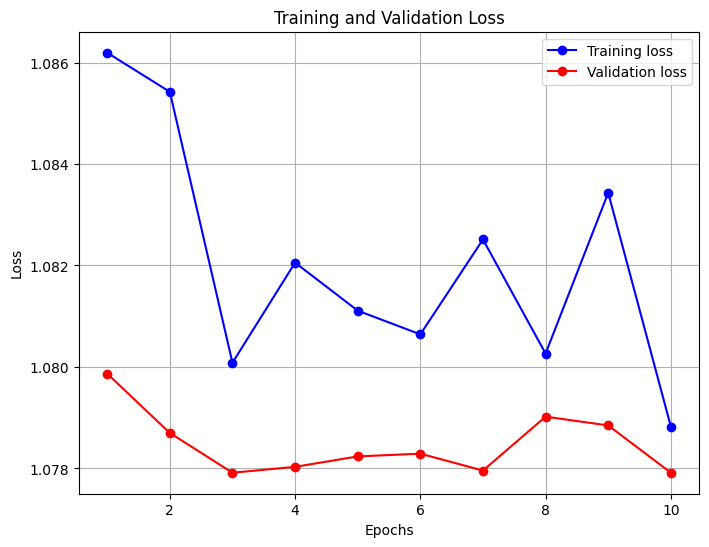

[DONE] Plot displayed.
[RESULT] LSTM Layers = 1 | Keras F1 = 0.184448 | Scratch F1 = 0.184448



In [6]:
lstm_lstmLayer_1 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmLayer_1.keras")
lstm_lstmLayer_1.history_path = Path("saved_models/lstm_lstmLayer_1_history.json")
lstm_lstmLayer_1.load_data()

if lstm_lstmLayer_1.model_path.exists() and lstm_lstmLayer_1.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmLayer_1.load_history()
else:
    lstm_lstmLayer_1.train(epochs=30, batch_size=32, lstm_layers=1, lstm_units=64)

keras_lstm_lstmLayer_1 = lstm_lstmLayer_1.evaluate_keras()
scratch_lstm_lstmLayer_1 = lstm_lstmLayer_1.evaluate_scratch()
lstm_lstmLayer_1.plot_history()
print(f"[RESULT] LSTM Layers = 1 | Keras F1 = {keras_lstm_lstmLayer_1:.6f} | Scratch F1 = {scratch_lstm_lstmLayer_1:.6f}\n")


### Layer LSTM = 3

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmLayer_3.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.4021 - loss: 1.0914 - val_accuracy: 0.3800 - val_loss: 1.0787
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3829 - loss: 1.0799 - val_accuracy: 0.3800 - val_loss: 1.0795
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4010 - loss: 1.0755 - val_accuracy: 0.3800 - val_loss: 1.0819
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3805 - loss: 1.0867 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3948 - loss: 1.0594 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3388 - loss: 1.0866 - val_accuracy: 0.3800 - val

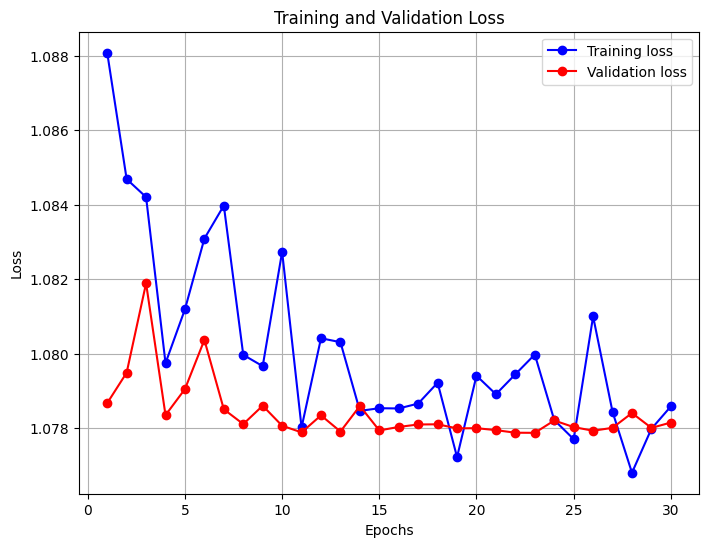

[DONE] Plot displayed.
[RESULT] LSTM Layers = 3 | Keras F1 = 0.182698 | Scratch F1 = 0.182698



In [7]:
lstm_lstmLayer_3 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmLayer_3.keras")
lstm_lstmLayer_3.history_path = Path("saved_models/lstm_lstmLayer_3_history.json")
lstm_lstmLayer_3.load_data()

if lstm_lstmLayer_3.model_path.exists() and lstm_lstmLayer_3.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmLayer_3.load_history()
else:
    lstm_lstmLayer_3.train(epochs=30, batch_size=32, lstm_layers=3, lstm_units=64)

keras_lstm_lstmLayer_3 = lstm_lstmLayer_3.evaluate_keras()
scratch_lstm_lstmLayer_3 = lstm_lstmLayer_3.evaluate_scratch()
lstm_lstmLayer_3.plot_history()
print(f"[RESULT] LSTM Layers = 3 | Keras F1 = {keras_lstm_lstmLayer_3:.6f} | Scratch F1 = {scratch_lstm_lstmLayer_3:.6f}\n")


### Layer LSTM = 5

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmLayer_5.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.3698 - loss: 1.0906 - val_accuracy: 0.3800 - val_loss: 1.0870
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3524 - loss: 1.0796 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3268 - loss: 1.0882 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3603 - loss: 1.0726 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3448 - loss: 1.0995 - val_accuracy: 0.3800 - val_loss: 1.0801
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3300 - loss: 1.0836 - val_accuracy: 0.3800 - val

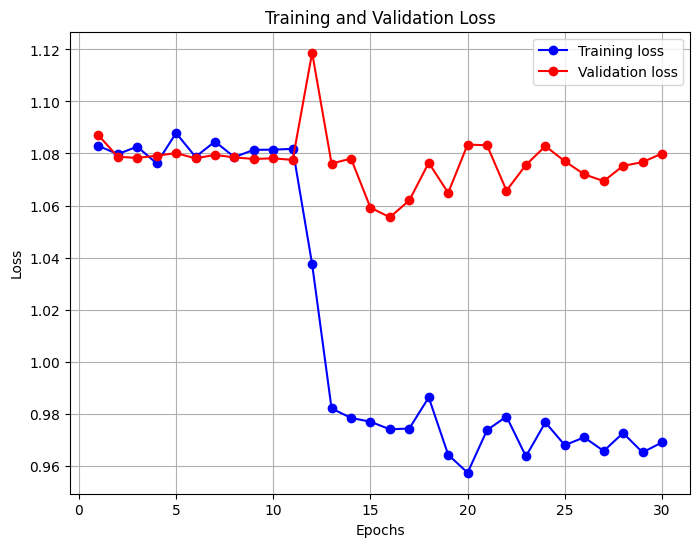

[DONE] Plot displayed.
[RESULT] LSTM Layers = 5 | Keras F1 = 0.310687 | Scratch F1 = 0.310687



In [8]:
lstm_lstmLayer_5 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmLayer_5.keras")
lstm_lstmLayer_5.history_path = Path("saved_models/lstm_lstmLayer_5_history.json")
lstm_lstmLayer_5.load_data()

if lstm_lstmLayer_5.model_path.exists() and lstm_lstmLayer_5.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmLayer_5.load_history()
else:
    lstm_lstmLayer_5.train(epochs=30, batch_size=32, lstm_layers=5, lstm_units=64)

keras_lstm_lstmLayer_5 = lstm_lstmLayer_5.evaluate_keras()
scratch_lstm_lstmLayer_5 = lstm_lstmLayer_5.evaluate_scratch()
lstm_lstmLayer_5.plot_history()
print(f"[RESULT] LSTM Layers = 5 | Keras F1 = {keras_lstm_lstmLayer_5:.6f} | Scratch F1 = {scratch_lstm_lstmLayer_5:.6f}\n")


## Variasi Hyperparameter Cells LSTM

### Cells LSTM = 8

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmCells_8.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3389 - loss: 1.0942 - val_accuracy: 0.3800 - val_loss: 1.0819
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3824 - loss: 1.0874 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3818 - loss: 1.0791 - val_accuracy: 0.3800 - val_loss: 1.0786
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3900 - loss: 1.0574 - val_accuracy: 0.3800 - val_loss: 1.0784
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4152 - loss: 1.0832 - val_accuracy: 0.3800 - val_loss: 1.0798
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3759 - loss: 1.0895 - val_accuracy: 0.3800 - val

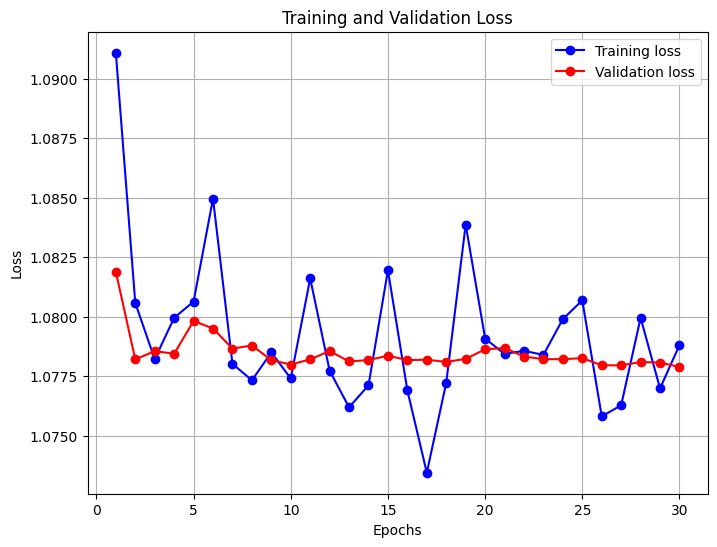

[DONE] Plot displayed.
[RESULT] LSTM Units = 8 | Keras F1 = 0.182698 | Scratch F1 = 0.182698



In [14]:
lstm_lstmCells_8 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmCells_8.keras")
lstm_lstmCells_8.history_path = Path("saved_models/lstm_lstmCells8_history.json")
lstm_lstmCells_8.load_data()

if lstm_lstmCells_8.model_path.exists() and lstm_lstmCells_8.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmCells_8.load_history()
else:
    lstm_lstmCells_8.train(epochs=30, batch_size=32, lstm_layers=1, lstm_units=8)

keras_lstm_lstmCells_8 = lstm_lstmCells_8.evaluate_keras()
scratch_lstm_lstmCells_8 = lstm_lstmCells_8.evaluate_scratch()
lstm_lstmCells_8.plot_history()
print(f"[RESULT] LSTM Units = 8 | Keras F1 = {keras_lstm_lstmCells_8:.6f} | Scratch F1 = {scratch_lstm_lstmCells_8:.6f}\n")


### Cells LSTM = 16

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmCells_16.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3491 - loss: 1.0975 - val_accuracy: 0.3800 - val_loss: 1.0829
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3787 - loss: 1.0812 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3753 - loss: 1.0750 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3877 - loss: 1.0740 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3362 - loss: 1.0867 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3858 - loss: 1.0742 - val_accuracy: 0.3800 - va

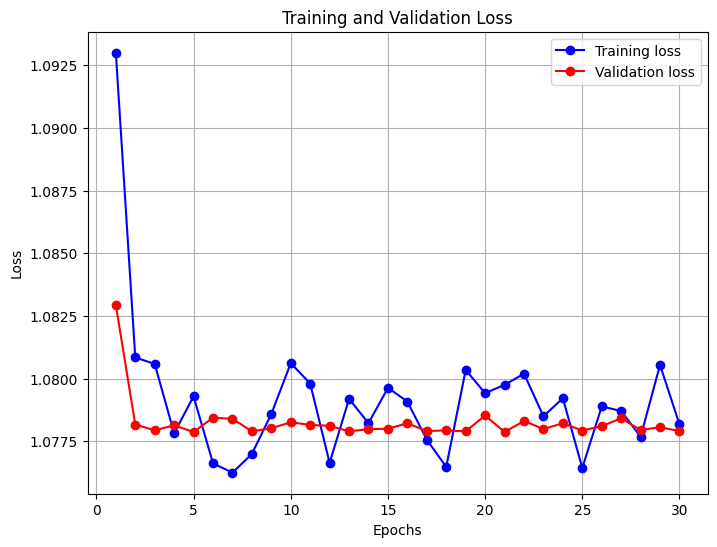

[DONE] Plot displayed.
[RESULT] LSTM Units = 16 | Keras F1 = 0.184448 | Scratch F1 = 0.184448



In [15]:
lstm_lstmCells_16 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmCells_16.keras")
lstm_lstmCells_16.history_path = Path("saved_models/lstm_lstmCells16_history.json")
lstm_lstmCells_16.load_data()

if lstm_lstmCells_16.model_path.exists() and lstm_lstmCells_16.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmCells_16.load_history()
else:
    lstm_lstmCells_16.train(epochs=30, batch_size=32, lstm_layers=1, lstm_units=16)

keras_lstm_lstmCells_16 = lstm_lstmCells_16.evaluate_keras()
scratch_lstm_lstmCells_16 = lstm_lstmCells_16.evaluate_scratch()
lstm_lstmCells_16.plot_history()
print(f"[RESULT] LSTM Units = 16 | Keras F1 = {keras_lstm_lstmCells_16:.6f} | Scratch F1 = {scratch_lstm_lstmCells_16:.6f}\n")


### Cells LSTM = 32

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_lstmCells_32.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3756 - loss: 1.0948 - val_accuracy: 0.3800 - val_loss: 1.0801
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3970 - loss: 1.0740 - val_accuracy: 0.3800 - val_loss: 1.0785
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4079 - loss: 1.0704 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3914 - loss: 1.0778 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3829 - loss: 1.0754 - val_accuracy: 0.3800 - val_loss: 1.0780
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3399 - loss: 1.0835 - val_accuracy: 0.3800 - va

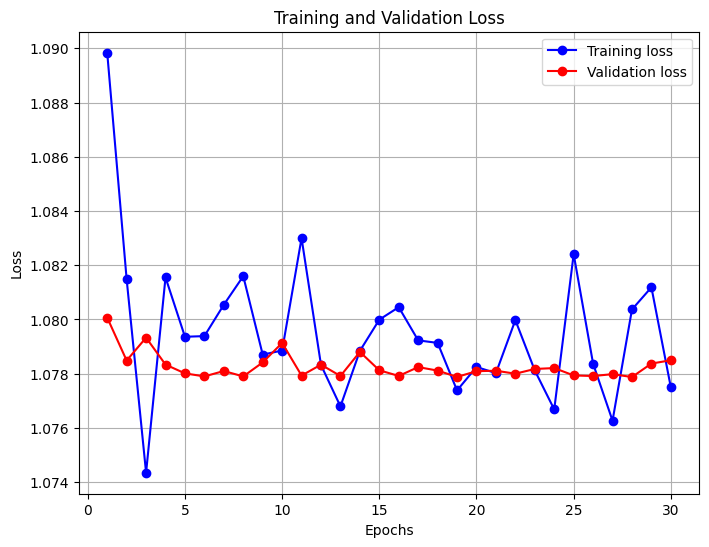

[DONE] Plot displayed.
[RESULT] LSTM Units = 32 | Keras F1 = 0.184448 | Scratch F1 = 0.184448



In [16]:
lstm_lstmCells_32 = LSTMSuite(save_dir="saved_models", model_name="lstm_lstmCells_32.keras")
lstm_lstmCells_32.history_path = Path("saved_models/lstm_lstmCells32_history.json")
lstm_lstmCells_32.load_data()

if lstm_lstmCells_32.model_path.exists() and lstm_lstmCells_32.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_lstmCells_32.load_history()
else:
    lstm_lstmCells_32.train(epochs=30, batch_size=32, lstm_layers=1, lstm_units=32)

keras_lstm_lstmCells_32 = lstm_lstmCells_32.evaluate_keras()
scratch_lstm_lstmCells_32 = lstm_lstmCells_32.evaluate_scratch()
lstm_lstmCells_32.plot_history()
print(f"[RESULT] LSTM Units = 32 | Keras F1 = {keras_lstm_lstmCells_32:.6f} | Scratch F1 = {scratch_lstm_lstmCells_32:.6f}\n")


## Variasi Hyperparameter Arah

### Unidirectional

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_unidirectional.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.3584 - loss: 1.0965 - val_accuracy: 0.3800 - val_loss: 1.0864
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3542 - loss: 1.0841 - val_accuracy: 0.3800 - val_loss: 1.0793
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3640 - loss: 1.0784 - val_accuracy: 0.3800 - val_loss: 1.0779
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3713 - loss: 1.0896 - val_accuracy: 0.3800 - val_loss: 1.0783
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3494 - loss: 1.0765 - val_accuracy: 0.3800 - val_loss: 1.0781
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3523 - loss: 1.0831 - val_accuracy: 0.3800 - 

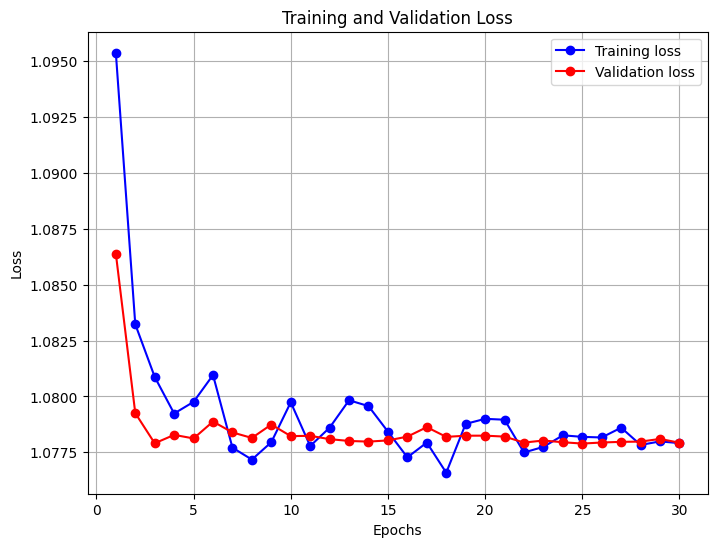

[DONE] Plot displayed.
[RESULT] Unidirectional | Keras F1 = 0.184448 | Scratch F1 = 0.184448



In [12]:
lstm_unidirectional = LSTMSuite(save_dir="saved_models", model_name="lstm_unidirectional.keras")
lstm_unidirectional.history_path = Path("saved_models/lstm_unidirectional_history.json")
lstm_unidirectional.load_data()

if lstm_unidirectional.model_path.exists() and lstm_unidirectional.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_unidirectional.load_history()
else:
    lstm_unidirectional.train(epochs=30, batch_size=32, lstm_layers=3, lstm_units=10, bidirectional=False)

keras_lstm_unidirectional = lstm_unidirectional.evaluate_keras()
scratch_lstm_unidirectional = lstm_unidirectional.evaluate_scratch()
lstm_unidirectional.plot_history()
print(f"[RESULT] Unidirectional | Keras F1 = {keras_lstm_unidirectional:.6f} | Scratch F1 = {scratch_lstm_unidirectional:.6f}\n")


### Bidirectional

[INIT] Initializing LSTMSuite with model path 'saved_models/lstm_bidirectional.keras'
[START] Loading dataset...
[DONE] Dataset loaded:
  - train: (500, 100), (500,)
  - val: (100, 100), (100,)
  - test: (400, 100), (400,)
[START] Training LSTM model...
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.3571 - loss: 1.0957 - val_accuracy: 0.5500 - val_loss: 1.0792
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4349 - loss: 1.0661 - val_accuracy: 0.5600 - val_loss: 1.0053
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5724 - loss: 0.9498 - val_accuracy: 0.5800 - val_loss: 0.8970
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6648 - loss: 0.7832 - val_accuracy: 0.6100 - val_loss: 0.8202
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7049 - loss: 0.6448 - val_accuracy: 0.6500 - val_loss: 0.7726
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7611 - loss: 0.5015 - val_accuracy: 0.6300 - v

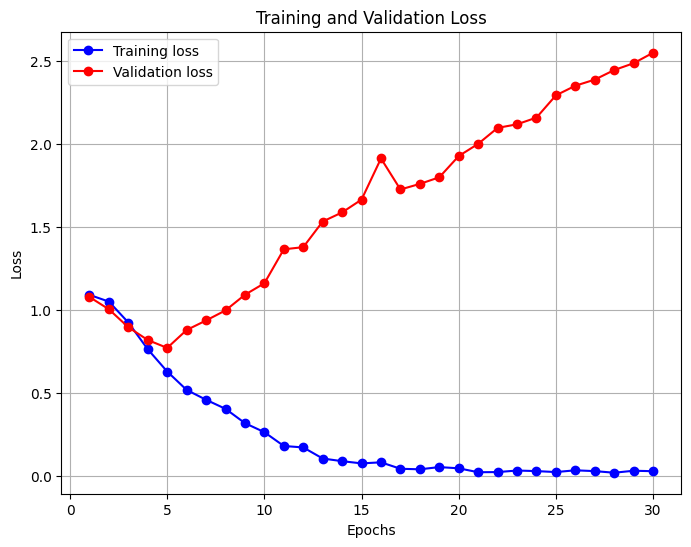

[DONE] Plot displayed.
[RESULT] Bidirectional | Keras F1 = 0.636144 | Scratch F1 = 0.636144



In [13]:
lstm_bidirectional = LSTMSuite(save_dir="saved_models", model_name="lstm_bidirectional.keras")
lstm_bidirectional.history_path = Path("saved_models/lstm_bidirectional_history.json")
lstm_bidirectional.load_data()

if lstm_bidirectional.model_path.exists() and lstm_bidirectional.history_path.exists():
    print("[INFO] Model and history already exist. Skipping training and loading history...")
    lstm_bidirectional.load_history()
else:
    lstm_bidirectional.train(epochs=30, batch_size=32, lstm_layers=3, lstm_units=10, bidirectional=True)

keras_lstm_bidirectional = lstm_bidirectional.evaluate_keras()
scratch_lstm_bidirectinoal = lstm_bidirectional.evaluate_scratch()
lstm_bidirectional.plot_history()
print(f"[RESULT] Bidirectional | Keras F1 = {keras_lstm_bidirectional:.6f} | Scratch F1 = {scratch_lstm_bidirectinoal:.6f}\n")
